<a href="https://colab.research.google.com/github/elaefry/TubesTKC/blob/main/Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Color Correction**

In [ ]:
from imutils.perspective import four_point_transform
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
def find_color_card(image):
	arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
	arucoParams = cv2.aruco.DetectorParameters_create()
	(corners, ids, rejected) = cv2.aruco.detectMarkers(image,
		arucoDict, parameters=arucoParams)

	try:
		ids = ids.flatten()

		i = np.squeeze(np.where(ids == 923))
		topLeft = np.squeeze(corners[i])[0]

		i = np.squeeze(np.where(ids == 1001))
		topRight = np.squeeze(corners[i])[1]

		i = np.squeeze(np.where(ids == 241))
		bottomRight = np.squeeze(corners[i])[2]

		i = np.squeeze(np.where(ids == 1007))
		bottomLeft = np.squeeze(corners[i])[3]

	except:
		return None

	cardCoords = np.array([topLeft, topRight,
		bottomRight, bottomLeft])
	card = four_point_transform(image, cardCoords)

	return card

In [ ]:
args = {
    "reference": "references.jpg",
    "input": "ISIC_0000022.jpg"
}

[INFO] loading images...


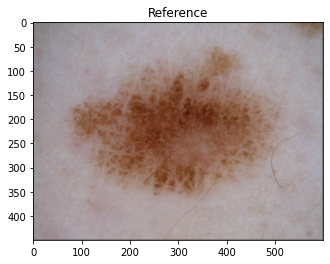

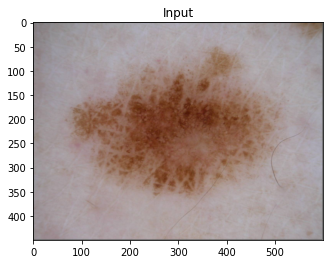

In [ ]:
print("[INFO] loading images...")
ref = cv2.imread(args["reference"])
image = cv2.imread(args["input"])

ref = imutils.resize(ref, width=600)
image = imutils.resize(image, width=600)

plt_imshow("Reference", ref)
plt_imshow("Input", image)

In [ ]:
print("[INFO] finding color matching cards...")
refCard = find_color_card(ref)
imageCard = find_color_card(image)

if refCard is None or imageCard is None:
	print("[INFO] could not find color matching card in both images")

[INFO] finding color matching cards...
[INFO] could not find color matching card in both images


# **Detect Low Contrast**

In [15]:
from skimage.exposure import is_low_contrast
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [16]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [17]:
args = {
    "input": "examples",
    "thresh": 0.35
}

In [18]:
imagePaths = sorted(list(list_images(args["input"])))

for (i, imagePath) in enumerate(imagePaths):
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=450)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	edged = cv2.Canny(blurred, 30, 150)

	text = "Low contrast: No"
	color = (0, 255, 0)

	if is_low_contrast(gray, fraction_threshold=args["thresh"]):
		text = "Low contrast: Yes"
		color = (0, 0, 255)

	else:
		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		c = max(cnts, key=cv2.contourArea)

		cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

	cv2.putText(image, text, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
		color, 2)

	plt_imshow("Image", image)
	plt_imshow("Edge", edged)

Implementing low contrast frame detection in real-time video streams

In [19]:
args = {
    "input": "20211113_211719.mp4",
    "thresh": 0.35,
    "output": "output.avi"
}

In [ ]:
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

while True:
	(grabbed, frame) = vs.read()

	if not grabbed:
		print("[INFO] no frame read from stream - exiting")
		break

	frame = imutils.resize(frame, width=450)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	edged = cv2.Canny(blurred, 30, 150)

	text = "Low contrast: No"
	color = (0, 255, 0)

	if is_low_contrast(gray, fraction_threshold=args["thresh"]):
		text = "Low contrast: Yes"
		color = (0, 0, 255)

	else:
		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		c = max(cnts, key=cv2.contourArea)

		cv2.drawContours(frame, [c], -1, (0, 255, 0), 2)

	cv2.putText(frame, text, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
		color, 2)

	output = np.dstack([edged] * 3)
	output = np.hstack([frame, output])

	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(output.shape[1], output.shape[0]), True)
  
	if writer is not None:
		writer.write(output)
  
vs.release()
vs.release()

if writer is not None:
	writer.release()

In [23]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [24]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

# **Gamma Correction**

In [ ]:
from matplotlib import pyplot as plt
from __future__ import print_function
import numpy as np
import argparse
import cv2

In [ ]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
def adjust_gamma(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")

	return cv2.LUT(image, table)

In [ ]:
args = {
	"image": "ISIC_0000013.jpg"
}

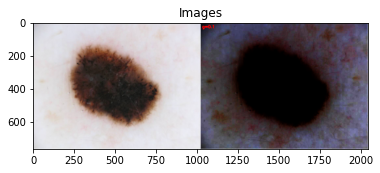

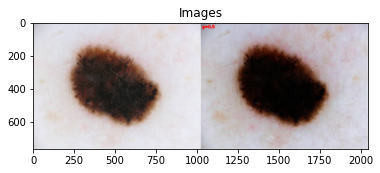

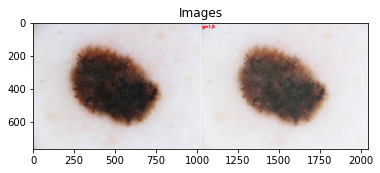

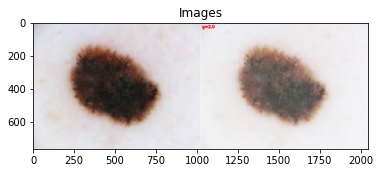

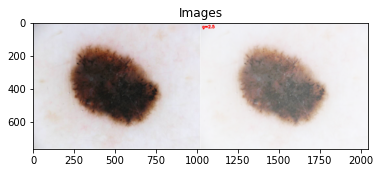

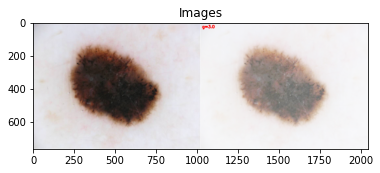

In [ ]:
original = cv2.imread(args["image"])

for gamma in np.arange(0.0, 3.5, 0.5):
	if gamma == 1:
		continue

	gamma = gamma if gamma > 0 else 0.1
	adjusted = adjust_gamma(original, gamma=gamma)
	cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
	plt_imshow("Images", np.hstack([original, adjusted]))

# **Histogram**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

In [ ]:
def plt_imshow(title, image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [ ]:
def plot_histogram(image, title, mask=None):
	chans = cv2.split(image)
	colors = ("b", "g", "r")
	plt.figure()
	plt.title(title)
	plt.xlabel("Bins")
	plt.ylabel("# of Pixels")

	for (chan, color) in zip(chans, colors):
		hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
		plt.plot(hist, color=color)
		plt.xlim([0, 256])

	plt.show()

In [ ]:
args = {
    "image": "ISIC_0000043.jpg"
}

In [ ]:
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

(0.0, 256.0)

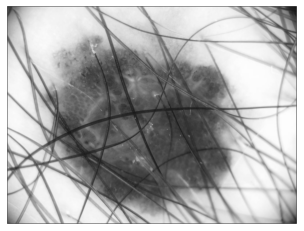

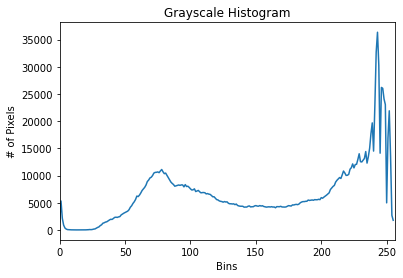

In [ ]:
plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

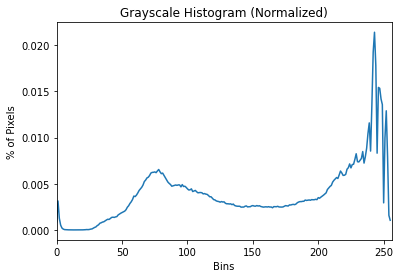

In [ ]:
hist /= hist.sum()

plt.figure()
plt.title("Grayscale Histogram (Normalized)")
plt.xlabel("Bins")
plt.ylabel("% of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()

Creating color histograms with OpenCV


In [ ]:

image = cv2.imread(args["image"])

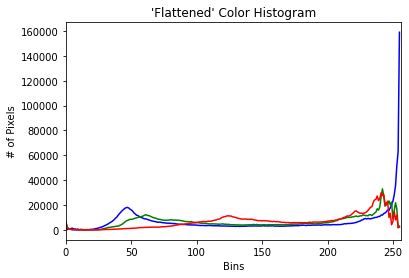

In [ ]:

chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")

for (chan, color) in zip(chans, colors):
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color=color)
	plt.xlim([0, 256])

2D histogram shape: (32, 32), with 1024 values


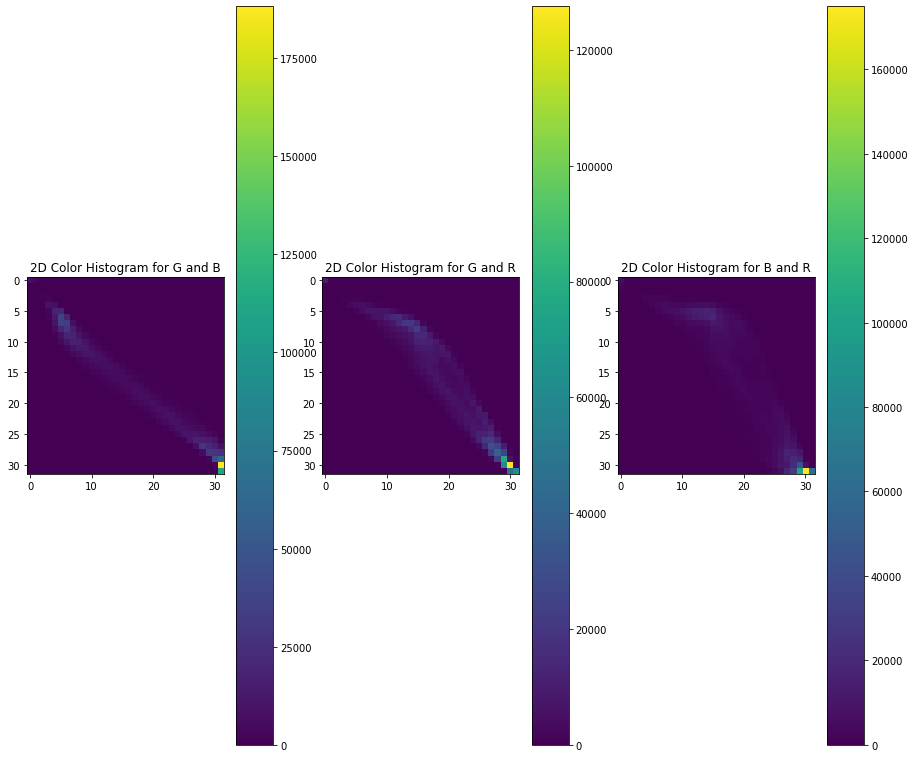

In [ ]:
fig = plt.figure(figsize=(15, 25))
ax = fig.add_subplot(131)
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], None, [32, 32],
	[0, 256, 0, 256])
p = ax.imshow(hist, interpolation="nearest")
ax.set_title("2D Color Histogram for G and B")
plt.colorbar(p)

ax = fig.add_subplot(132)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], None, [32, 32],
	[0, 256, 0, 256])
p = ax.imshow(hist, interpolation="nearest")
ax.set_title("2D Color Histogram for G and R")
plt.colorbar(p)

ax = fig.add_subplot(133)
hist = cv2.calcHist([chans[0], chans[2]], [0, 1], None, [32, 32],
	[0, 256, 0, 256])
p = ax.imshow(hist, interpolation="nearest")
ax.set_title("2D Color Histogram for B and R")
plt.colorbar(p)

print("2D histogram shape: {}, with {} values".format(
	hist.shape, hist.flatten().shape[0]))

In [ ]:
hist = cv2.calcHist([image], [0, 1, 2],
	None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
print("3D histogram shape: {}, with {} values".format(
	hist.shape, hist.flatten().shape[0]))

3D histogram shape: (8, 8, 8), with 512 values


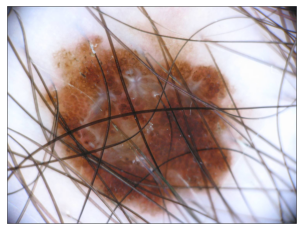

In [ ]:
plt.figure()
plt.axis("off")
plt.imshow(imutils.opencv2matplotlib(image))

plt.show()

Computing image histograms for masked regions with OpenCV


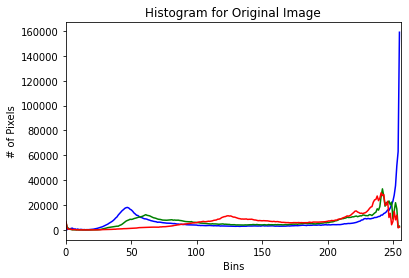

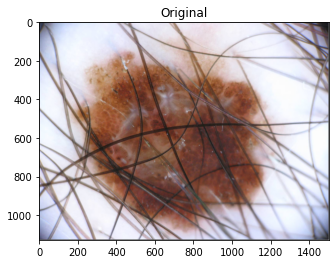

In [ ]:
image = cv2.imread("ISIC_0000043.jpg")
plot_histogram(image, "Histogram for Original Image")
plt_imshow("Original", image)

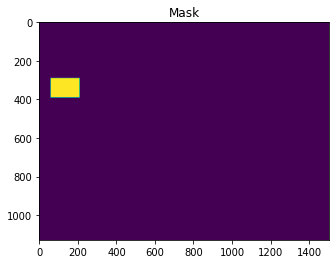

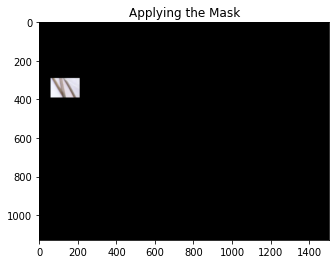

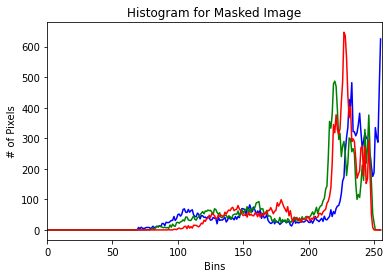

In [ ]:
mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.rectangle(mask, (60, 290), (210, 390), 255, -1)
plt_imshow("Mask", mask)

masked = cv2.bitwise_and(image, image, mask=mask)
plt_imshow("Applying the Mask", masked)

plot_histogram(image, "Histogram for Masked Image", mask=mask)

plt.show()

# **Histogram Equalization**

In [1]:
import matplotlib.pyplot as plt
import argparse
import cv2

In [2]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [3]:
args = {
    "image": "skincancer.jpg"
}

In [4]:
print("[INFO] loading input image...")
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("[INFO] performing histogram equalization...")
equalized = cv2.equalizeHist(gray)

[INFO] loading input image...
[INFO] performing histogram equalization...


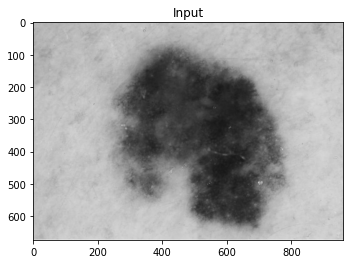

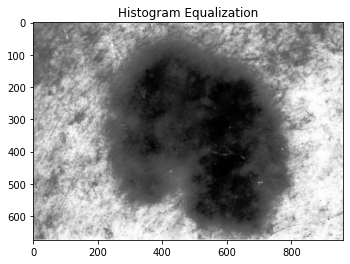

In [5]:
# show the original grayscale image and equalized image
plt_imshow("Input", gray)
plt_imshow("Histogram Equalization", equalized)

Implementing adaptive histogram equalization with OpenCV


In [6]:
args = {
    "image": "skincancer.jpg",
    "clip": 2.0,
    "tile": 8
}

In [7]:
print("[INFO] loading input image...")
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("[INFO] applying CLAHE...")
clahe = cv2.createCLAHE(clipLimit=args["clip"],
	tileGridSize=(args["tile"], args["tile"]))
equalized = clahe.apply(gray)

[INFO] loading input image...
[INFO] applying CLAHE...


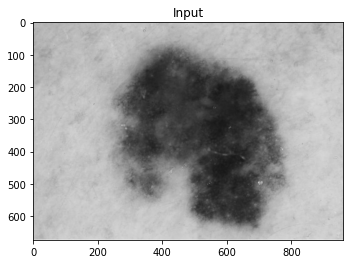

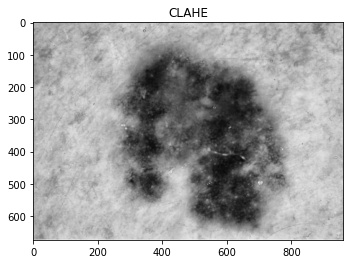

In [8]:
plt_imshow("Input", gray)
plt_imshow("CLAHE", equalized)

# **Histogram Matching**

In [ ]:
from skimage import exposure
import matplotlib.pyplot as plt
import argparse
import cv2

In [ ]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
args = {
    "source": "ISIC_0000013.jpg",
    "reference": "ISIC_0000022.jpg"
}

[INFO] loading source and reference images...
[INFO] performing histogram matching...


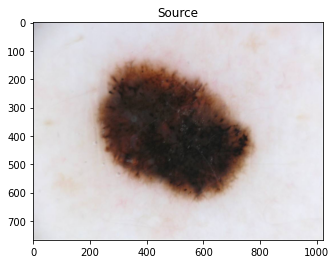

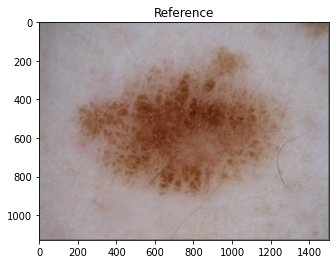

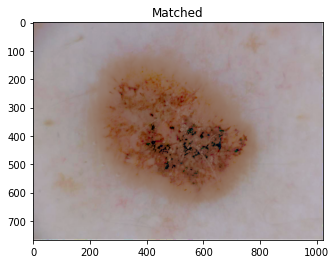

In [ ]:
print("[INFO] loading source and reference images...")
src = cv2.imread(args["source"])
ref = cv2.imread(args["reference"])

print("[INFO] performing histogram matching...")
multi = True if src.shape[-1] > 1 else False
matched = exposure.match_histograms(src, ref, multichannel=multi)

plt_imshow("Source", src)
plt_imshow("Reference", ref)
plt_imshow("Matched", matched)

Text(0.5, 1.0, 'Matched')

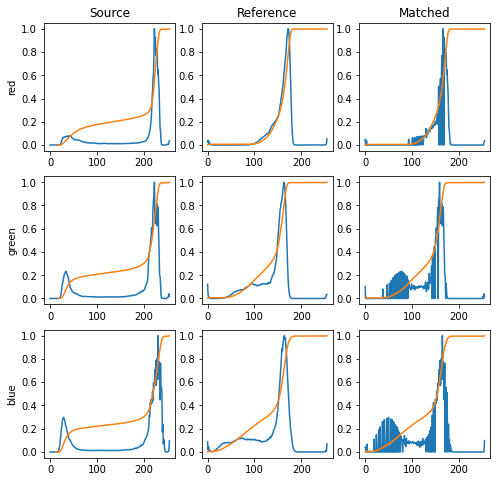

In [ ]:
(fig, axs) =  plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for (i, image) in enumerate((src, ref, matched)):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	for (j, color) in enumerate(("red", "green", "blue")):
		(hist, bins) = exposure.histogram(image[..., j],
			source_range="dtype")
		axs[j, i].plot(bins, hist / hist.max())

		(cdf, bins) = exposure.cumulative_distribution(image[..., j])
		axs[j, i].plot(bins, cdf)

		axs[j, 0].set_ylabel(color)
  
axs[0, 0].set_title("Source")
axs[0, 1].set_title("Reference")
axs[0, 2].set_title("Matched")